# Version 2 – Improved Training Strategy (Same UNet)

Goal:
Improve Mean IoU and minority-class segmentation using better loss
functions and data handling, without changing model architecture.


1. **Checking** GPU integration.


In [ ]:
!nvidia-smi



Sat Jan 17 06:10:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2. Mounting FALCON DATASET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd Offroad_Segmentation_Training_Dataset
!ls


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset
Offroad_Segmentation_Training_Dataset


In [ ]:
%cd Offroad_Segmentation_Training_Dataset
!ls

/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset
train  val


In [ ]:
!ls train


images	masks


In [ ]:
# Go to the dataset root (you are already here, but ensure)
%cd /content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


In [ ]:
!ls train
!ls val


images	masks
images	masks


In [ ]:
!ls train/images | head
!ls train/masks | head


cc0000012.png
cc0000013.png
cc0000014.png
cc0000015.png
cc0000017.png
cc0000018.png
cc0000021.png
cc0000022.png
cc0000023.png
cc0000025.png
cc0000012.png
cc0000013.png
cc0000014.png
cc0000015.png
cc0000017.png
cc0000018.png
cc0000021.png
cc0000022.png
cc0000023.png
cc0000025.png


In [ ]:
!pwd


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


3.Installing Dependencies


In [ ]:
!pip install -U segmentation-models

import tensorflow as tf
import os
import numpy as np

# Set framework to tensorflow for segmentation-models
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm


  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
Segmentation Models: using `tf.keras` framework.


LABELING


In [ ]:
BACKBONE = 'resnet50'
CLASSES = 10
IMG_SIZE = 256

preprocess_input = sm.get_preprocessing(BACKBONE)


In [ ]:
# Official dataset label IDs → class indices (0–9)
LABEL_MAP = {
    100: 0,    # Trees
    200: 1,    # Lush Bushes
    300: 2,    # Dry Grass
    500: 3,    # Dry Bushes
    550: 4,    # Ground Clutter
    600: 5,    # Flowers
    700: 6,    # Logs
    800: 7,    # Rocks
    7100: 8,   # Landscape
    10000: 9   # Sky
}

CLASSES = 10


In [ ]:
import cv2

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    return image


In [ ]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    # Ensure integer type
    mask = mask.astype(np.int32)

    mask = cv2.resize(
        mask,
        (IMG_SIZE, IMG_SIZE),
        interpolation=cv2.INTER_NEAREST
    )

    remapped_mask = np.zeros_like(mask, dtype=np.uint8)

    for original_id, class_idx in LABEL_MAP.items():
        remapped_mask[mask == original_id] = class_idx

    remapped_mask = tf.keras.utils.to_categorical(
        remapped_mask,
        num_classes=CLASSES
    )

    return remapped_mask


In [ ]:
def data_generator(image_dir, mask_dir, batch_size=4):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    while True:
        images = []
        masks = []

        for img_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, mask_file)

            images.append(load_image(img_path))
            masks.append(load_mask(mask_path))

            if len(images) == batch_size:
                yield np.array(images), np.array(masks)
                images, masks = [], []


In [ ]:
BASE_PATH = "/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset"


In [ ]:
train_images = os.path.join(BASE_PATH, "train", "images")
train_masks  = os.path.join(BASE_PATH, "train", "masks")

val_images = os.path.join(BASE_PATH, "val", "images")
val_masks  = os.path.join(BASE_PATH, "val", "masks")


In [ ]:
print("Train images:", len(os.listdir(train_images)))
print("Train masks:", len(os.listdir(train_masks)))
print("Val images:", len(os.listdir(val_images)))
print("Val masks:", len(os.listdir(val_masks)))


Train images: 2857
Train masks: 2857
Val images: 317
Val masks: 317


In [ ]:
train_gen = data_generator(train_images, train_masks, batch_size=4)
val_gen   = data_generator(val_images, val_masks, batch_size=4)


In [ ]:
images, masks = next(train_gen)

print(images.shape)
print(masks.shape)
print("Unique class indices in mask:",
      np.unique(np.argmax(masks[0], axis=-1)))


(4, 256, 256, 3)
(4, 256, 256, 10)
Unique class indices in mask: [1 2 3 4 7 8 9]


In [ ]:
!pip install tensorflow==2.12.0 keras==2.12.0
!pip install segmentation-models==1.0.1 efficientnet==1.0.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"


In [ ]:
import tensorflow as tf
import segmentation_models as sm


In [ ]:
print("TensorFlow:", tf.__version__)
print("DeepLabV3Plus available:", hasattr(sm, "DeepLabV3Plus"))


TensorFlow: 2.19.0
DeepLabV3Plus available: False


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
!pip uninstall -y segmentation-models efficientnet


Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Successfully uninstalled segmentation-models-1.0.1
Found existing installation: efficientnet 1.0.0
Uninstalling efficientnet-1.0.0:
  Successfully uninstalled efficientnet-1.0.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


#Changed part of V2


In [ ]:
from collections import Counter

class_counts = Counter()

for _ in range(100):
    _, masks = next(train_gen)
    labels = np.argmax(masks, axis=-1)
    class_counts.update(labels.flatten())

print(class_counts)


Counter({np.int64(9): 10698397, np.int64(2): 7667896, np.int64(8): 5550117, np.int64(3): 1019204, np.int64(4): 716312, np.int64(7): 508152, np.int64(1): 51518, np.int64(0): 2804})


In [ ]:
num_classes = 10
epsilon = 1e-6

total_pixels = sum(class_counts.values())

class_weight_vector = np.zeros(num_classes, dtype=np.float32)

for cls in range(num_classes):
    if cls in class_counts:
        class_weight_vector[cls] = total_pixels / (num_classes * class_counts[cls])
    else:
        class_weight_vector[cls] = total_pixels / (num_classes * epsilon)

# Normalize weights to prevent explosion
class_weight_vector = class_weight_vector / np.mean(class_weight_vector)

print("Class weight vector:", class_weight_vector)
print("Length:", len(class_weight_vector))


Class weight vector: [1.7831669e-09 9.7053462e-11 6.5206933e-13 4.9057893e-12 6.9801985e-12
 5.0000000e+00 5.0000000e+00 9.8395762e-12 9.0088191e-13 4.6735977e-13]
Length: 10


In [ ]:
print(class_weight_vector)
assert len(class_weight_vector) == 10


[1.7831669e-09 9.7053462e-11 6.5206933e-13 4.9057893e-12 6.9801985e-12
 5.0000000e+00 5.0000000e+00 9.8395762e-12 9.0088191e-13 4.6735977e-13]


In [48]:
class_weight_tensor = tf.constant(class_weight_vector, dtype=tf.float32)

def weighted_dice_ce_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weights = tf.reduce_sum(y_true * class_weight_tensor, axis=-1)
    ce = ce * weights
    dl = dice_loss(y_true, y_pred)
    return ce + dl


In [49]:
def unet(input_shape=(256, 256, 3), num_classes=10):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(b)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(u3)
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(u2)
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(c6)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c6)

    return models.Model(inputs, outputs)


In [50]:
model = unet(input_shape=(256, 256, 3), num_classes=10)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_62[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_64[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_66[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 64, 64,    │          0 │ conv2d_67[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 64, 64,    │          0 │ up_sampling2d_12… │
│ (Concatenate)       │ 768)              │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_12[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_68[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (None, 128, 128,  │          0 │ conv2d_69[0][0] 

 Total params: 7,783,498 (29.69 MB)

 Trainable params: 7,783,498 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

In [52]:
model = unet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=weighted_dice_ce_loss,
    metrics=["accuracy"]
)


In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/unet_offroad_v2_best.h5",
        monitor="val_loss",
        save_best_only=True
    )
]


In [54]:
history = model.fit(
    train_gen,
    steps_per_epoch=30,
    validation_data=val_gen,
    validation_steps=10,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5316 - loss: 0.4761

30/30 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.5355 - loss: 0.4722 - val_accuracy: 0.7375 - val_loss: 0.2683
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7033 - loss: 0.3074 - val_accuracy: 0.5139 - val_loss: 0.4870
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7269 - loss: 0.2763 - val_accuracy: 0.6586 - val_loss: 0.8011
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8213 - loss: 0.1787 - val_accuracy: 0.6115 - val_loss: 0.3939


In [56]:
def mean_iou(y_true, y_pred, num_classes=10):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        if union == 0:
            continue
        ious.append(intersection / union)

    return np.mean(ious)


In [57]:
images, masks = next(val_gen)
preds = model.predict(images)

print("Mean IoU:", mean_iou(masks, preds))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Mean IoU: 0.13259432343941555


In [58]:
ious = []

for _ in range(10):  # evaluate on 10 validation batches
    images, masks = next(val_gen)
    preds = model.predict(images)
    ious.append(mean_iou(masks, preds))

print("Mean IoU over 10 batches:", np.mean(ious))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Mean IoU over 10 batches: 0.13951712902105748


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


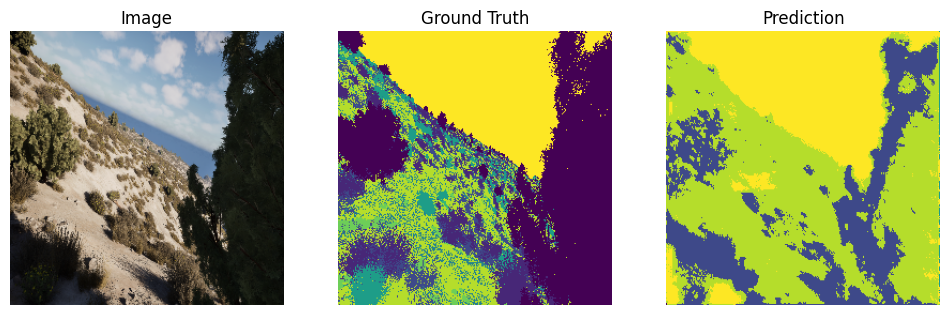

In [68]:
images, masks = next(val_gen)
preds = model.predict(images)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(images[0])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(np.argmax(masks[0], axis=-1))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(np.argmax(preds[0], axis=-1))
plt.axis("off")

plt.show()
